## Multi-class PyTorch model


### 1 Creating multi-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


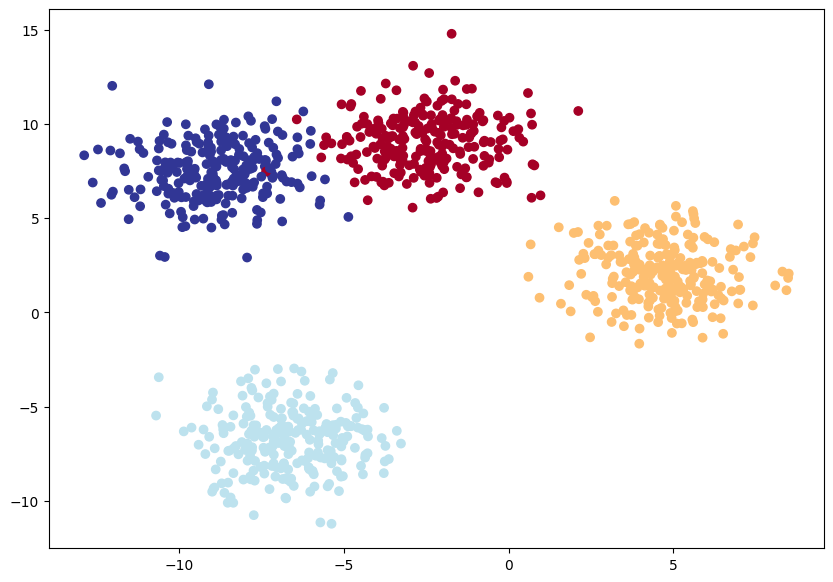

In [589]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


> **Question:** Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

In [590]:
import numpy as np

# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 2 Building a multi-class classification model in PyTorch

Let's create a subclass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in your multi-class classification problem).
* `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.


In [591]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## **Задание**
# *Досягти на датасеті щонайменше 95% accuracy, а за можливості навіть 100% (accuracy вимірюється на test сеті) із якомога меншою кількістю параметрів нейронної мережі.*

**Эксперимент 1**

В предложенном варианте модели не была применена функция активации, при этом, за 100 эпох была получена довольно высокая точность на тренировочных данных и на тестовых. Таких показателей точности удалось добиться из-за малой диффузии данных:
Epoch: 90 | Loss: 0.03278, Acc: 99.25% | Test Loss: 0.02430, Test Acc: 99.50%

Применим в модели функцию активации ReLU между входным слоем и скрытым слоем, а также между скрытым слоем и внешним слоем, которая добавит нелинейность, при этом количество нейронов скрытого слоя оставим по-умолчанию = 8, количество эпох 100.

Обучение прошло быстро, уже по прошествии 30-ти эпох, точность была выше 99%:

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%

**Эксперимент 2**

Применим в модели функцию активации ReLU между скрытым слоем и внешним слоем, которая добавит нелинейность, при этом уменьшим количество нейронов скрытого слоя до 2, количество эпох при этом пришлось увеличивать до 1400, т.к. при меньшем количестве эпох нейронная сеть оставалась недотренированной. Показатель точности на тестовом датасете так же была достигнута условиям задания.

Epoch: 1380 | Loss: 0.10454, Acc: 97.88% | Test Loss: 0.08878, Test Acc: 99.50%
Epoch: 1390 | Loss: 0.38042, Acc: 85.88% | Test Loss: 0.09866, Test Acc: 98.00%
Epoch: 1400 | Loss: 0.09785, Acc: 98.25% | Test Loss: 0.08282, Test Acc: 99.00%

**Эксперимент 3**

Применим в модели функцию активации ReLU между входным слоем и внешним слоем, которая добавит нелинейность, при этом уменьшим количество скрытого слоя до 0, количество эпох приняли до 260, т.к. при меньшем количестве эпох нейронная сеть оставалась недотренированной. Показатель точности на тестовом датасете так же была достигнута условиям задания.

Epoch: 230 | Loss: 0.35222, Acc: 82.50% | Test Loss: 0.35810, Test Acc: 71.00%
Epoch: 240 | Loss: 0.20453, Acc: 96.12% | Test Loss: 0.18381, Test Acc: 97.50%
Epoch: 250 | Loss: 0.11870, Acc: 98.75% | Test Loss: 0.10619, Test Acc: 99.50%
Epoch: 260 | Loss: 0.09659, Acc: 99.00% | Test Loss: 0.08709, Test Acc: 99.50%

## По результату третьего эксперимента были достигнуты поставленные условия задания при заданных исходных данных, благодаря тому что функция ReLU является хорошим аппроксиматором

In [592]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            # nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=2).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=4, bias=True)
  )
)


### 3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.


In [593]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

### 4 Getting prediction probabilities for a multi-class PyTorch model


In [594]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.6074,  1.9568,  3.5105,  2.6007],
        [ 1.7675, -1.1054,  3.9093,  2.8509],
        [ 0.3410, -0.0998,  0.5451,  0.1045],
        [ 0.3410, -0.0998,  0.5451,  0.1045],
        [ 1.7934, -1.4744,  2.6562,  1.8089]], grad_fn=<SliceBackward0>)

In [595]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

Flow: `logits -> prediction probabilities -> prediction labels` 

In [596]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.4324,  1.8332,  3.9219,  2.9366],
        [ 2.8062, -3.1795,  1.3308,  0.6730],
        [ 0.3410, -0.0998,  0.5451,  0.1045],
        [-0.4057,  1.3213,  2.1374,  1.4530],
        [ 1.1775, -0.0362,  4.9659,  3.7490]], grad_fn=<SliceBackward0>)
tensor([[0.0085, 0.0820, 0.6623, 0.2472],
        [0.7409, 0.0019, 0.1694, 0.0878],
        [0.2733, 0.1759, 0.3352, 0.2157],
        [0.0388, 0.2183, 0.4938, 0.2491],
        [0.0171, 0.0051, 0.7544, 0.2234]], grad_fn=<SliceBackward0>)


In [597]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [598]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0085, 0.0820, 0.6623, 0.2472], grad_fn=<SelectBackward0>)
tensor(2)


### 5 Creating a training and testing loop for a multi-class PyTorch model


In [599]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 260

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.93678, Acc: 25.12% | Test Loss: 1.37500, Test Acc: 42.50%
Epoch: 10 | Loss: 0.68888, Acc: 76.38% | Test Loss: 0.70462, Test Acc: 79.00%
Epoch: 20 | Loss: 0.61666, Acc: 74.88% | Test Loss: 0.64340, Test Acc: 75.50%
Epoch: 30 | Loss: 0.57783, Acc: 75.12% | Test Loss: 0.60621, Test Acc: 76.00%
Epoch: 40 | Loss: 0.54864, Acc: 75.50% | Test Loss: 0.57703, Test Acc: 77.50%
Epoch: 50 | Loss: 0.52477, Acc: 75.88% | Test Loss: 0.55278, Test Acc: 78.00%
Epoch: 60 | Loss: 0.50475, Acc: 76.38% | Test Loss: 0.53223, Test Acc: 79.00%
Epoch: 70 | Loss: 0.48771, Acc: 76.88% | Test Loss: 0.51464, Test Acc: 80.00%
Epoch: 80 | Loss: 0.47305, Acc: 77.38% | Test Loss: 0.49946, Test Acc: 81.00%
Epoch: 90 | Loss: 0.46033, Acc: 78.12% | Test Loss: 0.48622, Test Acc: 81.00%
Epoch: 100 | Loss: 0.44920, Acc: 79.12% | Test Loss: 0.47459, Test Acc: 81.50%
Epoch: 110 | Loss: 0.43937, Acc: 79.12% | Test Loss: 0.46429, Test Acc: 82.00%
Epoch: 120 | Loss: 0.43059, Acc: 80.00% | Test Loss: 0.45506, T

### 6 Making and evaluating predictions with a PyTorch multi-class model


In [600]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 6.4997, 11.9466,  0.7346, -4.4904],
        [ 4.9181, -7.6624, -2.6271,  7.6209],
        [-0.0924, -0.4737,  2.4089, -0.9521],
        [ 3.0826,  7.0207,  1.9448, -3.6806],
        [10.4214,  7.0950, -3.0315,  1.6948],
        [ 5.7910, -8.9147, -3.5044,  9.1145],
        [-0.0924, -0.4737,  2.4089, -0.9521],
        [ 8.4240,  2.4014, -2.7348,  3.3969],
        [-0.0924, -0.4737,  2.4089, -0.9521],
        [ 8.9839,  4.0397, -2.7450,  2.7013]])

> **Note:** It's possible to skip the `torch.softmax()` function and go straight from `predicted logits -> predicted labels` by calling `torch.argmax()` directly on the logits.
>
> For example, `y_preds = torch.argmax(y_logits, dim=1)`, this saves a computation step (no `torch.softmax()`) but results in no prediction probabilities being available to use. 

In [601]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


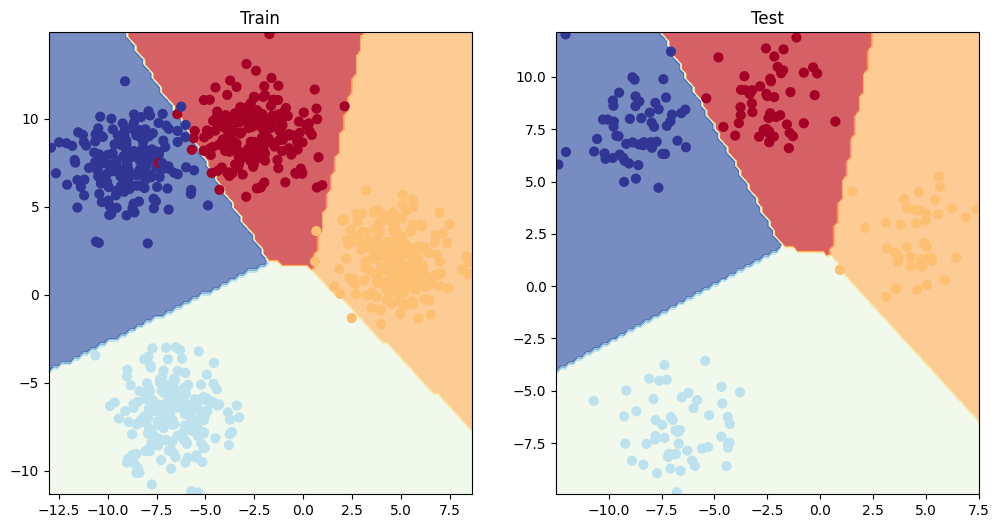

In [602]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate you classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html). 

Let's try the `torchmetrics.Accuracy` metric out.




In [603]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)